<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Data/blob/main/script/MLP_ofdm_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt

# Divide a bit stream into 4-bit parallel groups
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

# Map an array of parallel bit groups into another array of the mapped 16-QAM constellation points
def Mapping(parallelbits):
    return np.array([mapping_table[tuple(pb)] for pb in parallelbits])

# Assign the the mapped QAM constellation points and pilot points to an array indexed by the sub-carriers
def OFDM_Carriers(QAM, pilot):
    ofdm_sym = np.zeros(K, dtype=complex) # the overall K subcarriers
    ofdm_sym[pilotCarriers] = pilot  # allocate the pilot subcarriers
    ofdm_sym[dataCarriers] = QAM  # allocate the data subcarriers
    return ofdm_sym

def IDFT(frequency_weights):
    return np.fft.ifft(frequency_weights)

def prependCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def transmit(signal):
    convolution = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolution**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolution.shape)+1j*np.random.randn(*convolution.shape))

    return convolution + noise

def removeCP(signal):
    return signal[CP:(CP+K)]

def DFT(OFDM_intime):
    return np.fft.fft(OFDM_intime)

# Apply the equalizer derived from the DL model to the received OFDM symbol
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

# Map the predicted QAM raw data to the closest constellation points
def constellate(QAM_raw):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    QAM_approx = np.zeros((55,), dtype=complex)

    for i in range(len(QAM_raw)):
      start = 1
      for m in range(len(constellation)):
        dist = abs(QAM_raw[i] - constellation[m])
        if start == 1:
          min = dist
          QAM_approx[i] = constellation[m]
          start = 0
        elif dist < min:
          min = dist
          QAM_approx[i] = constellation[m]

    return QAM_approx

def PS(bits):
    return bits.reshape((-1,))


allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]
Number of all carriers:  64
Number of data carriers:  55
Number of pilot carriers:  9


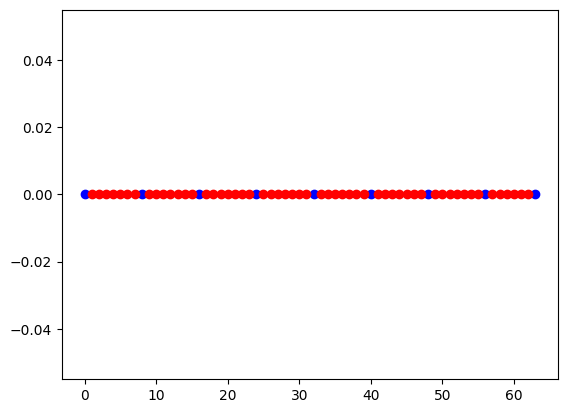

In [ ]:
K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
D = len(dataCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
print("Number of all carriers: ", len(allCarriers))
print("Number of data carriers: ", len(dataCarriers))
print("Number of pilot carriers: ", len(pilotCarriers))

plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

Number of payload bits in an OFDM symbol:  220


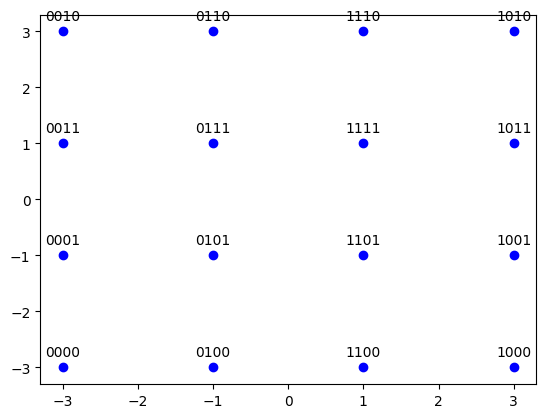

In [ ]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadsize = len(dataCarriers)*mu  # number of payload bits per OFDM symbol
print("Number of payload bits in an OFDM symbol: ", payloadsize)

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

demapping_table = {v : k for k, v in mapping_table.items()}

for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

channelResponse shape:  (64,)


Text(0, 0.5, '$|cir(t)|$')

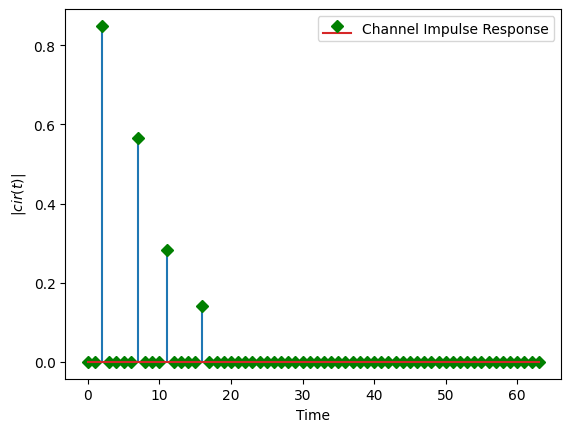

In [ ]:
# A hypothetical channel is set up to transmit data through The OFDM pipeline
# It is characterised by a 4-tap delay line of channel impulse responses
# The channel simulates the effect of a multipath delay spread of 25% of the transmission period

channelResponse = np.zeros((64,), dtype=complex)
channelResponse[2] = 0.6 + 0.6j
channelResponse[7] = 0.4 + 0.4j
channelResponse[11] = 0.2 + 0.2j
channelResponse[16] = 0.1 + 0.1j

#channelResponse = np.array([1, 0, 0.3+0.3j])
print ("channelResponse shape: ", channelResponse.shape)
# channelResponse = np.array([1, 0, 0, 0.2+0.2j])  # the impulse response of the wireless channel
timeline = np.arange(64)
plt.stem(timeline, abs(channelResponse), markerfmt='gD', label='Channel Impulse Response')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|cir(t)|$')

Hf_CIR shape:  (64,)
Hf_CIR:  [ 1.3       +1.3j         1.63915046+0.34475894j  1.2094679 -0.36696829j
  0.67779334-0.45522109j  0.4707371 -0.31438597j  0.40561047-0.25072114j
  0.36429696-0.15721892j  0.49610333-0.06746736j  0.7       -0.21715729j
  0.68083901-0.50157575j  0.54435848-0.61643904j  0.59215307-0.71740542j
  0.57779103-1.1629141j  -0.01110907-1.65298462j -0.95024778-1.47562373j
 -1.40504207-0.6321834j  -1.1       +0.1j        -0.57886732+0.26220812j
 -0.29225183+0.10081246j -0.21146319-0.11997019j -0.33414217-0.37779103j
 -0.74704239-0.46107381j -1.15143652-0.09492316j -1.10947498+0.46199494j
 -0.78284271+0.7j        -0.67536659+0.71494739j -0.6922164 +1.0035786j
 -0.28035811+1.45883735j  0.51438597+1.42631917j  0.98630035+0.78665447j
  0.81640361+0.15840766j  0.39807501-0.02809973j  0.1       +0.1j
 -0.02809973+0.39807501j  0.15840766+0.81640361j  0.78665447+0.98630035j
  1.42631917+0.51438597j  1.45883735-0.28035811j  1.0035786 -0.6922164j
  0.71494739-0.67536659j  0.7 

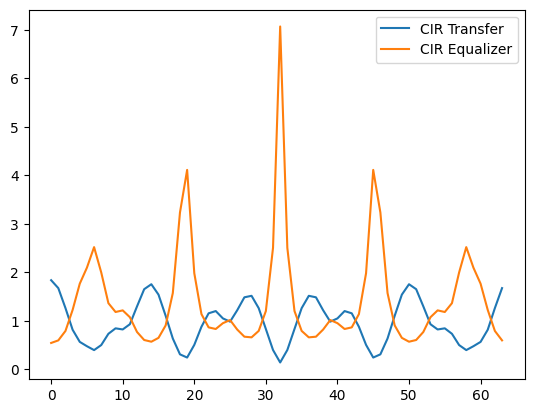

In [ ]:
Hf_CIR = np.fft.fft(channelResponse, K)
Eq_CIR = np.reciprocal(Hf_CIR)
plt.plot(allCarriers, abs(Hf_CIR), label='CIR Transfer')
plt.plot(allCarriers, abs(Eq_CIR), label='CIR Equalizer')
plt.legend()

SNRdb = 25  # signal to noise-ratio in dB at the receiver
print ("Hf_CIR shape: ", Hf_CIR.shape)
print ("Hf_CIR: ", Hf_CIR)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Prepare random data samples for training a DL model to estimate the transmission channel
def create_learning_data(sampleize, testingsize):
  for i in range(sampleize):
    bits = np.random.binomial(n=1, p=0.5, size=payloadsize)
    SP_bits = SP(bits)
    QAM_payload = Mapping(SP_bits)
    OFDM_symbol = OFDM_Carriers(QAM_payload, pilotValue)
    OFDM_time = IDFT(OFDM_symbol)
    CP_OFDM_time = prependCP(OFDM_time)

    OFDM_RX = transmit(CP_OFDM_time)
    OFDM_RX_stripped = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_stripped)

    pilot_output = OFDM_demod[pilotCarriers]
    H_pilot = pilot_output/pilotValue
    H_known = OFDM_demod/OFDM_symbol

    if i == 0:
      X = H_pilot.reshape(1,P)
      Y = H_known.reshape(1,K)
    else:
      X = np.append(X, H_pilot.reshape(1,P), axis=0)
      Y = np.append(Y, H_known.reshape(1,K), axis=0)

  X_training, X_testing = X[:-testingsize], X[-testingsize:]
  Y_training, Y_testing = Y[:-testingsize], Y[-testingsize:]

  return X_training, X_testing, Y_training, Y_testing

sampleize = 120
testingsize = 20
X_training, X_testing, Y_training, Y_testing = create_learning_data(sampleize, testingsize)
print("X_training.shape: ", X_training.shape)
print("Y_training.shape: ", Y_training.shape)
print("X_testing.shape: ", X_testing.shape)
print("Y_testing.shape: ", Y_testing.shape)

X_training.shape:  (100, 9)
Y_training.shape:  (100, 64)
X_testing.shape:  (20, 9)
Y_testing.shape:  (20, 64)


In [ ]:
# Build a MLP DL model to derive the channel transfer function from the known gains for the pilot subcarriers.

def MLP_modeling(X_training, Y_training, X_testing, Y_testing):
  input_dim = X_training.shape[1]
  output_dim = Y_training.shape[1]
  model = Sequential()
  # model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) # input input_dim (9) -> output 256
  # model.add(Dense(128, activation='relu', kernel_initializer='he_normal')) # input 256 -> output 128
  model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) # input input_dim (9) -> output 128
  model.add(Dense(output_dim)) # input 128 -> output output_dim (64)
  model.summary()

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # fit the model
  model.fit(X_training, Y_training, epochs=100, batch_size=32, verbose=2, validation_data=(X_testing, Y_testing))

  mse, mae = model.evaluate(X_testing, Y_testing, verbose=0)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))
  return model

RX_training, IX_training = X_training.real, X_training.imag
RX_testing, IX_testing = X_testing.real, X_testing.imag
RY_training, IY_training = Y_training.real, Y_training.imag
RY_testing, IY_testing = Y_testing.real, Y_testing.imag

rofdm_model = MLP_modeling(RX_training, RY_training, RX_testing, RY_testing)
iofdm_model = MLP_modeling(IX_training, IY_training, IX_testing, IY_testing)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
Total params: 9536 (37.25 KB)
Trainable params: 9536 (37.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4/4 - 2s - loss: 1.3979 - mae: 0.9470 - val_loss: 1.0930 - val_mae: 0.7973 - 2s/epoch - 565ms/step
Epoch 2/100
4/4 - 0s - loss: 1.0023 - mae: 0.7502 - val_loss: 0.7723 - val_mae: 0.6296 - 86ms/epoch - 22ms/step
Epoch 3/100
4/4 - 0s - loss: 0.7043 - mae: 0.5909 - val_loss: 0.5341 - val_mae: 0.4912 - 77ms/epoch - 19ms/step
Epoch 4/100
4/4 - 0s - loss: 0.4840 - mae: 0.4567 - val_loss: 0.3618 - val_mae: 0.3

In [ ]:
# A random bit stream is generated and fed into the OFDM simulation pipe
# It will be transmitted through a hypothetical channel estimated by a MLP deep learning model.
# Data will be pulled from the other end of the pipe and compared with the input bits.

bits = np.random.binomial(n=1, p=0.5, size=payloadsize)
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:50])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

Bits count:  220
First 20 bits:  [0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 1 1 0 1 1 1 1 0 1 0 0]
Mean of bits (should be around 0.5):  0.5181818181818182


In [ ]:
SP_bits = SP(bits)
print ("SP_bits length: ", len(SP_bits))
print ("First 10 bit groups")
print (SP_bits[:10,:])

SP_bits length:  55
First 10 bit groups
[[0 0 1 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]
 [1 1 0 0]
 [0 1 0 0]
 [0 0 1 1]
 [0 1 1 1]
 [0 1 0 1]]


In [ ]:
QAM_payload = Mapping(SP_bits)
print ("QAM_payload array length: ", len(QAM_payload))
print ("QAM_payload element type: ", QAM_payload.dtype)
print ("First 8 QAM_payload symbols and bits:")
print (SP_bits[:8,:])
print (QAM_payload[:8])

QAM_payload array length:  55
QAM_payload element type:  complex128
First 8 QAM_payload symbols and bits:
[[0 0 1 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]
 [1 1 0 0]
 [0 1 0 0]
 [0 0 1 1]]
[-3.+1.j -3.-3.j  3.-3.j  3.-3.j -1.+3.j  1.-3.j -1.-3.j -3.+1.j]


In [ ]:
OFDM_symbol = OFDM_Carriers(QAM_payload, pilotValue)
print ("ODFM_symbol shape: ", OFDM_symbol.shape)
print ("ODFM_symbol array length: ", len(OFDM_symbol))
print ("ODMF_symbol element type: ", OFDM_symbol.dtype)

ODFM_symbol shape:  (64,)
ODFM_symbol array length:  64
ODMF_symbol element type:  complex128


In [ ]:
OFDM_time = IDFT(OFDM_symbol)
print ("OFDM_time shape: ", OFDM_time.shape)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

OFDM_time shape:  (64,)
Number of OFDM samples in time-domain before CP:  64


In [ ]:
CP_OFDM_time = prependCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(CP_OFDM_time))

Number of OFDM samples in time domain with CP:  80


Number of received OFDM_RX samples in time domain:  143


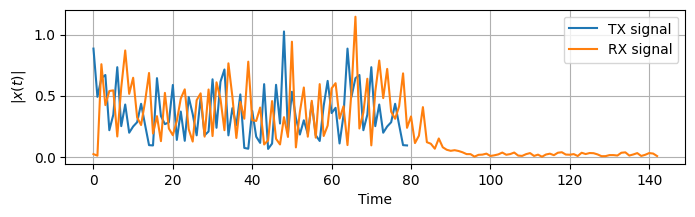

In [ ]:
OFDM_TX = CP_OFDM_time
OFDM_RX = transmit(OFDM_TX)
print ("Number of received OFDM_RX samples in time domain: ", len(OFDM_RX))
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [ ]:
OFDM_RX_stripped = removeCP(OFDM_RX)
print ("Number of received OFDM_RX_stripped samples in time domain: ", len(OFDM_RX_stripped))

Number of received OFDM_RX_stripped samples in time domain:  64


In [ ]:
OFDM_demod = DFT(OFDM_RX_stripped)
print ("OFDM_demod shape: ", OFDM_demod.shape)
print ("Number of OFDM_infreq samples in frequency domain: ", len(OFDM_demod))

pilot_output = OFDM_demod[pilotCarriers]
H_pilot = pilot_output/pilotValue
print ("H_pilot.shape: ", H_pilot.shape)

OFDM_demod shape:  (64,)
Number of OFDM_infreq samples in frequency domain:  64
H_pilot.shape:  (9,)


In [ ]:
# Use the MLP model to predict the channel transfer gains for all subcarriers

RH_pilot = H_pilot.real.reshape(1, P)
IH_pilot = H_pilot.imag.reshape(1, P)
print("RH_pilot.shape: ", RH_pilot.shape)
print("IH_pilot.shape: ", IH_pilot.shape)

RH_predict = rofdm_model.predict(RH_pilot)
IH_predict = iofdm_model.predict(IH_pilot)
print("RH_predict.shape: ", RH_predict.shape)
print("RH_predict: ", RH_predict)
print("IH_predict.shape: ", IH_predict.shape)
print("IH_predict: ", IH_predict)

RH_pilot.shape:  (1, 9)
IH_pilot.shape:  (1, 9)
1/1 [==============================] - 0s 54ms/step
RH_predict.shape:  (1, 64)
RH_predict:  [[ 1.2822448   1.622147    1.2463531   0.68808883  0.5012765   0.37752274
   0.34566057  0.49630028  0.6816944   0.6270322   0.5541263   0.55275995
   0.56295615  0.02311673 -0.9811013  -1.3736082  -1.0943927  -0.57586205
  -0.28186294 -0.19343974 -0.34475216 -0.76063883 -1.1465614  -1.0667895
  -0.768727   -0.67460346 -0.71280247 -0.2713623   0.52030194  0.9957373
   0.8402963   0.4105289   0.12004086 -0.04916459  0.180123    0.80428016
   1.4071091   1.423407    0.9581375   0.7257778   0.7529259   0.4453283
  -0.1402218  -0.49030888 -0.3950653  -0.12969267  0.11585373  0.2656589
   0.1334769  -0.6691254  -1.46205    -1.6287755  -1.1654545  -0.68915427
  -0.63794863 -0.524321   -0.19381586 -0.06866248 -0.1867419  -0.1894935
  -0.30683437 -0.45876357 -0.36117128  0.3370911 ]]
IH_predict.shape:  (1, 64)
IH_predict:  [[ 1.2949781   0.37441945 -0.3603

In [ ]:
# Apply the equalizer of the predicted channel tranfer gains to the received OFDM symbols

RH_predict = RH_predict.reshape(K,)
IH_predict = IH_predict.reshape(K,)
H_predict = RH_predict + 1j*IH_predict
print("H_predict.shape: ", H_predict.shape)
print("H_predict: ", H_predict)

equalized_H_predict = equalize(OFDM_demod, H_predict)
print("equalized_H_predict.shape: ", equalized_H_predict.shape)
print("equalized_H_predict: ", equalized_H_predict)

H_predict.shape:  (64,)
H_predict:  [ 1.2822448 +1.2949781j   1.622147  +0.37441945j  1.2463531 -0.36031115j
  0.68808883-0.47339693j  0.5012765 -0.27371293j  0.37752274-0.22714634j
  0.34566057-0.18027781j  0.49630028-0.00560503j  0.6816944 -0.22262543j
  0.6270322 -0.49394694j  0.5541263 -0.57669044j  0.55275995-0.7172678j
  0.56295615-1.1403197j   0.02311673-1.6908866j  -0.9811013 -1.5102444j
 -1.3736082 -0.62153125j -1.0943927 +0.13981661j -0.57586205+0.29842693j
 -0.28186294+0.08311601j -0.19343974-0.06467999j -0.34475216-0.38803867j
 -0.76063883-0.44443434j -1.1465614 -0.11131882j -1.0667895 +0.44090205j
 -0.768727  +0.6707629j  -0.67460346+0.70865846j -0.71280247+0.9954969j
 -0.2713623 +1.4774948j   0.52030194+1.4582775j   0.9957373 +0.79631054j
  0.8402963 +0.15120704j  0.4105289 -0.03051275j  0.12004086+0.10046662j
 -0.04916459+0.48834863j  0.180123  +0.8172152j   0.80428016+0.9820881j
  1.4071091 +0.5059076j   1.423407  -0.28332245j  0.9581375 -0.7105227j
  0.7257778 -0.66678

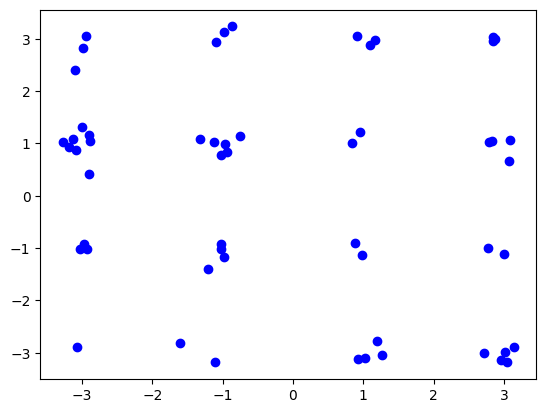

In [ ]:
QAM_predict = equalized_H_predict[dataCarriers]
plt.plot(QAM_predict.real, QAM_predict.imag, 'bo');

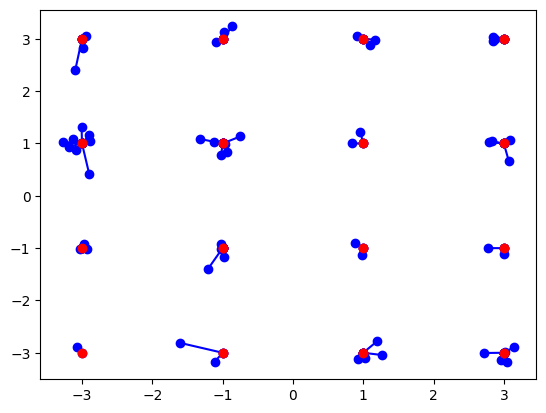

In [ ]:
# Locate the QAM constellation points for the QAM predictions

QAM_constell = constellate(QAM_predict)
PS_predict = np.vstack([demapping_table[c] for c in QAM_constell])

for pre, con in zip(QAM_predict, QAM_constell):
    plt.plot([pre.real, con.real], [pre.imag, con.imag], 'b-o');
    plt.plot(con.real, con.imag, 'ro')

In [ ]:
bits_predict = PS(PS_predict)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_predict))/len(bits))
print("1. First 100 bits of bits:")
print(bits[:100])
print("2. First 100 bits of bits_predict:")
print(bits_predict[:100])

Obtained Bit error rate:  0.0
1. First 100 bits of bits:
[0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1
 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0]
2. First 100 bits of bits_predict:
[0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1
 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0]


pilots shape:  (9,)
pilots :  [-0.13848069+7.82994913j  2.53901998+1.54710627j -3.72525319-2.89695537j
 -4.54624884-0.34109408j  0.23009078+0.67246116j  4.5705658 -0.24409998j
  3.55561687-3.01106526j -2.76294085+1.59795657j -3.86252499+5.8000293j ]
Hest_at_pilots shape:  (9,)
Hest_at_pilots :  [ 1.28191141+1.32807164j  0.68102104-0.16531895j -1.10370143+0.13804964j
 -0.81455715+0.70085913j  0.15042532+0.0737284j   0.72107764-0.8024443j
  0.0907586 -1.09444702j -0.19416405+0.72681624j  0.32291738+1.61042572j]
HfCIR_at_pilots shape:  (9,)
HfCIR_at_pilots :  [ 1.3       +1.3j         0.7       -0.21715729j -1.1       +0.1j
 -0.78284271+0.7j         0.1       +0.1j         0.7       -0.78284271j
  0.1       -1.1j        -0.21715729+0.7j         0.34475894+1.63915046j]
Hest shape:  (64,)


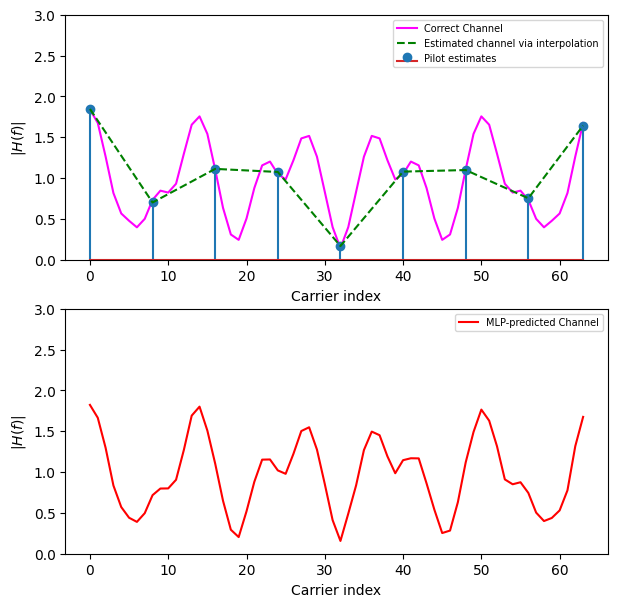

In [ ]:
import scipy

# Compare between deep learning and spline interpolation for channel estimation

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    # OFDM_demod[f] = Hest[f] * OFDM_symbol[f]
    # OFDM_dmod[pilotCarriers] = Hest[pilotCarriers] * OFDM_symbol[pilotCarriers]
    # OFDM_dmod[pilotCarriers] = Hest[pilotCarriers] * pilotValue
    # Hest[pilotCarriers] = OFDM_dmod[pilotCarriers] / pilotValue

    Hest_at_pilots = OFDM_demod[pilotCarriers] / pilotValue # divide by the transmitted pilot values
    HfCIR_at_pilots = Hf_CIR[pilotCarriers]

    print("pilots shape: ", pilots.shape)
    print("pilots : ", pilots)
    print("Hest_at_pilots shape: ", Hest_at_pilots.shape)
    print("Hest_at_pilots : ", Hest_at_pilots)
    print("HfCIR_at_pilots shape: ", HfCIR_at_pilots.shape)
    print("HfCIR_at_pilots : ", HfCIR_at_pilots)

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.figure(figsize=(7,7))
    plt.subplot(2, 1, 1)
    plt.plot(allCarriers, abs(Hf_CIR), color='magenta', label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), 'g--', label='Estimated channel via interpolation')
    # plt.grid(True);
    plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=7)
    plt.ylim(0,3)

    plt.subplot(2, 1, 2)
    plt.plot(allCarriers, abs(H_predict), color='red', label='MLP-predicted Channel')
    # plt.grid(True);
    plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=7)
    plt.ylim(0,3)

    return Hest

Hest = channelEstimate(OFDM_demod)
print ("Hest shape: ", Hest.shape)